In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models

import PIL
import yelp_dataloader
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from sklearn import metrics
from matplotlib import pyplot as plt
from timeit import default_timer as timer
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print_every = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype =torch.FloatTensor if device == 'cpe' else torch.cuda.FloatTensor
print(device)
print(dtype)

cuda:0
<class 'torch.cuda.FloatTensor'>


In [3]:
def preprocess(img, size):
    t = T.Compose([
        T.Resize(size),
        T.RandomCrop(size),
        T.ToTensor()
    ])
    return t(img)

In [4]:
dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats'
file_name_prefix='yelp_resnet_'
num_batches=5
num_feats=512
start = timer()
meta_feats, photo_feats = yelp_dataloader.read_yelp_photo_feats(dir_path, file_name_prefix, num_batches, num_feats)
end = timer()
print('load time for Yelp features.', (end - start))
print(meta_feats.shape)
print(photo_feats.shape)

biz_dir_path = '/home/Afshin/cs231n/cs231n-project/yelp-resnet-biz-feats'
biz_file_name ='yelp_resnet_biz_feats.h5'
biz_id_feats, biz_id_labels = yelp_dataloader.read_yelp_biz_feats(biz_dir_path, biz_file_name)
biz_feats = biz_id_feats[:, 1:]
biz_labels = biz_id_labels[:, 1:]
print('biz_feats, ', biz_feats.shape)
print('biz_labels, ', biz_labels.shape)

Num_train = 1800
Num_dev = 100
Num_test = 100
X_train = biz_feats[:Num_train]
y_train = biz_labels[:Num_train]
X_dev = biz_feats[Num_train: Num_train + Num_dev]
y_dev = biz_labels[Num_train: Num_train + Num_dev]
X_test = biz_feats[Num_train + Num_dev: Num_train + Num_dev + Num_test]
y_test = biz_labels[Num_train + Num_dev: Num_train + Num_dev + Num_test]

/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_0.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_1.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_2.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_3.h5
/home/Afshin/cs231n/cs231n-project/yelp-resnet-feats/yelp_resnet_4.h5
load time for Yelp features. 10.809804101999987
(234842, 11)
(234842, 514)
biz_feats,  (2000, 512)
biz_labels,  (2000, 9)


In [ ]:
# Build model and load state_dict
resnet_yelp_file = '/home/Afshin/cs231n/cs231n-project/yelp-resnet.pt'
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 9)
state_dict = torch.load(resnet_yelp_file)
resnet.load_state_dict(state_dict)
resnet = resnet.to(device)

In [32]:
from sklearn.neural_network import MLPClassifier

optimal_size = 100
mpl = MLPClassifier(hidden_layer_sizes=(optimal_size))
mpl.fit(X_train,y_train)

mpl_train_pred = mpl.predict(X_train)
mpl_dev_pred = mpl.predict(X_dev)
f1_train = metrics.f1_score(y_train, mpl_train_pred, average='macro') 
f1_dev = metrics.f1_score(y_dev, mpl_dev_pred, average='macro')  
print('mpl train f1 = %f for hidden size %d' % (f1_train, optimal_size))
print('mpl dev f1 = %f for hidden size %d' % (f1_dev, optimal_size))

photo_proba = mpl.predict_proba(photo_feats[:,2:])
print('photo_proba, = ', photo_proba.shape)

mpl train f1 = 0.825443 for hidden size 100
mpl dev f1 = 0.834142 for hidden size 100
photo_proba, =  (234842, 9)


In [33]:
photo_dir = '/home/Afshin/cs231n/cs231n-project/yelp-data/train_photos'
img_size = 224
images = np.zeros((9, 3, img_size, img_size))
labels = np.zeros((9, 9))
counter = 0
for label in range(9):
    indices = np.argpartition(photo_proba[:,label], -1)[-1:]
    for ind in indices:
        photo_id = int(photo_feats[ind][0])
        label = meta_feats[ind][2:]
        labels[counter] = label
        photo_path = os.path.join(photo_dir, str(photo_id) + '.jpg')
        image = PIL.Image.open(photo_path)
        image = preprocess(image, size=img_size).numpy()
        images[counter] = image
        counter += 1
print('images, ', images.shape)
print('labels, ', labels.shape)
#file_path = os.path.join('/home/Afshin/cs231n/cs231n-project', 'saliency.png')
#show_images(images, 5, 9, file_path)

images,  (9, 3, 224, 224)
labels,  (9, 9)


In [34]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    model = model.to(device)
    X = X.type(dtype)
    y = y.type(dtype)
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    scores = model(X) # (N, D)
    scores = scores.type(dtype)
    
    #label_scores = scores * y # (N, D)
    #loss = torch.sum(label_scores)
    
    loss = 0
    for i in range(X.size()[0]):
        loss += scores[i, i]
        
    loss.backward()
    saliency, _ = torch.max(torch.abs(X.grad), 1)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [35]:
def show_saliency_maps(X, y, model, f):
    print(X.shape)
    print(y.shape)
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X.shape[0]
    fig = plt.figure(figsize=(18,4))
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].transpose(1,2,0))
        plt.axis('off')
        #plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(18, 4)
    plt.savefig(f)

(9, 3, 224, 224)
(9, 9)


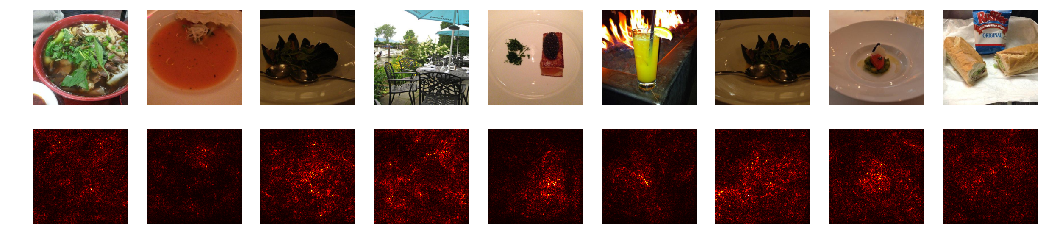

In [36]:
f = os.path.join('/home/Afshin/cs231n/cs231n-project', 'saliency.png')
show_saliency_maps(images, labels, resnet, f)

In [37]:
####### Class Visualization #######
from scipy.ndimage.filters import gaussian_filter1d

In [38]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
        
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / STD).tolist()),
        T.Normalize(mean=(-MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [56]:
def create_class_visualization(target_y, model, dtype, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()
    file_path = os.path.join('/home/Afshin/cs231n/cs231n-project', class_name + '.png') 
    fig = plt.figure(figsize=(4,4))
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        scores = model(img).squeeze()
        score = scores[target_y]
        score.backward()
        g = img.grad - 2*l2_reg*img
        with torch.no_grad():
            img += learning_rate * g
            img.grad.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-MEAN[c] / STD[c])
            hi = float((1.0 - MEAN[c]) / STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:            
            plt.imshow(deprocess(img.data.clone().cpu()))
            if t != num_iterations - 1:
                plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            else:
                plt.title(class_name)
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            if t != num_iterations - 1:
                plt.show()
            else:
                plt.savefig(file_path) 
    
    return deprocess(img.data.cpu())

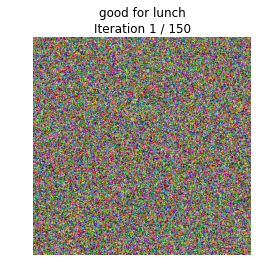

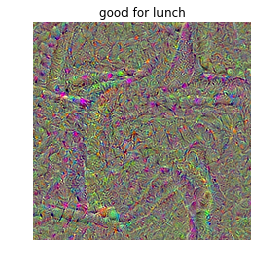

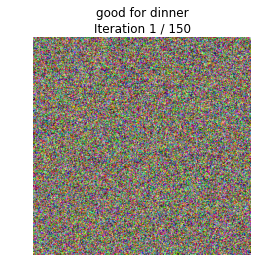

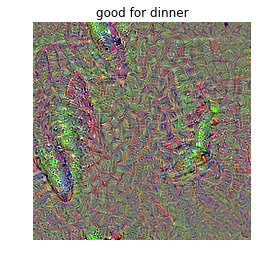

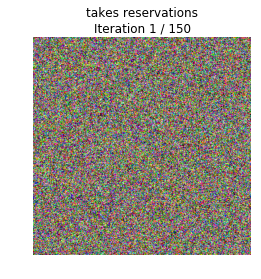

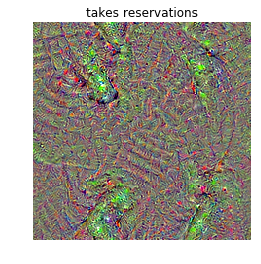

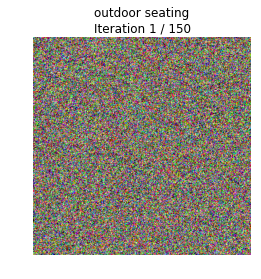

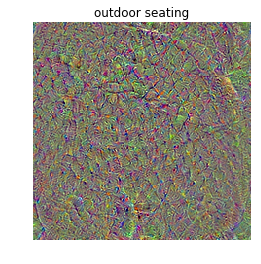

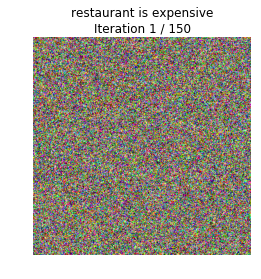

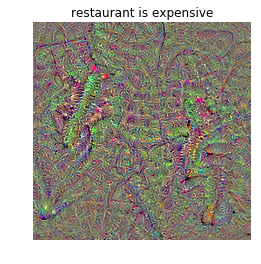

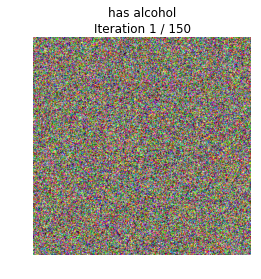

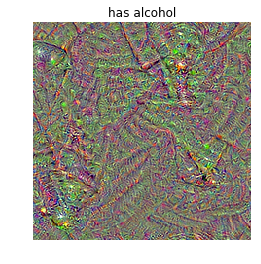

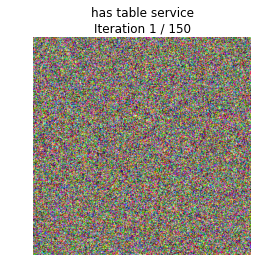

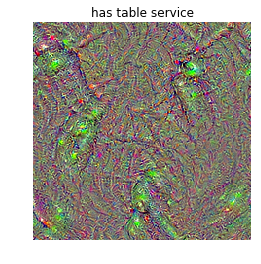

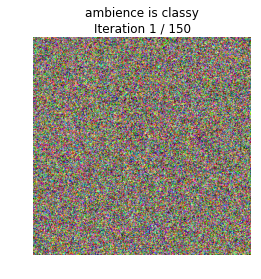

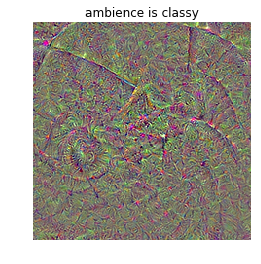

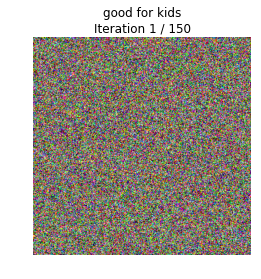

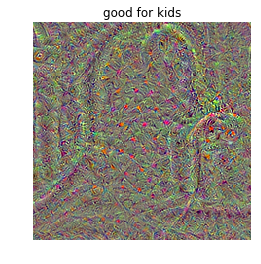

In [58]:
resnet.type(dtype)

labels = ['good for lunch', 'good for dinner', 'takes reservations', 'outdoor seating', \
         'restaurant is expensive', 'has alcohol', 'has table service', 'ambience is classy', 'good for kids']
for target_y in range(9):
    out = create_class_visualization(target_y, resnet, dtype, labels[target_y], show_every=200, num_iterations=150)